In [ ]:
#!pip install geopandas

In [104]:
import pandas as pd
from IPython.display import HTML
import os
import urllib.request
import xlrd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geopandas as gdf
from shapely.geometry import Point
import datetime
import geopy
import geopy.distance
import seaborn as sns
from geopandas import GeoDataFrame
from collections import Counter
import statsmodels.api as sm
import statsmodels.formula.api as smf
import collections
from itertools import compress
from sklearn.cluster import KMeans
import csv

#TO DO
Write a text intro
Clean notebook
Add an "open in colab" button
Get url download link for original csvs.

*   Write a text intro
*   Clean notebook
*   Add an "open in colab" button
*   Get url download link for original csvs.List item



In [9]:
import os
#os.chdir('../raw_data')

Note, if working from the Zenodo repository, set the working directory to the "raw_data" folder. Outputs from this script can be found in the "analysis_data" folder.

In [105]:
a =pd.read_csv('../analysis_data/pipeline_failures_storm.csv', low_memory=False)
a.DATE = pd.to_datetime(a.DATE)

In [106]:
a.columns

Index(['Unnamed: 0.1', 'PipeIDX', 'Unnamed: 0', 'CAUSE', 'DATE',
       'INCIDENT_CITY', 'INCIDENT_COUNTY', 'INCIDENT_STATE', 'ZIP_CODE',
       'INSTALLATION_YEAR', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'MANYR',
       'TYPE', 'ITMYR', 'year', 'Point', 'PipeIdx', 'name', 'month', 'day',
       'hour', 'lat', 'long', 'status', 'category', 'wind', 'pressure',
       'tropicalstorm_force_diameter', 'hurricane_force_diameter', 'DATETIME1',
       'date', 'start_date', 'time', 'pointh', 'end_date', 'dateTime',
       'HurIdx', 'diftime', 'distance', 'frequency', 'max_int', 'fourplus'],
      dtype='object')

In [107]:
nan_count = a['diftime'].isna().sum()
nan_count

np.int64(15228)

In [108]:
nan_count = a['CAUSE'].isna().sum()
nan_count

np.int64(0)

<Axes: >

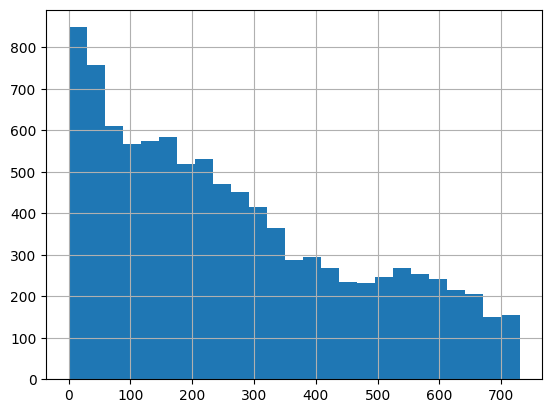

In [119]:
a.diftime.hist(bins = 25)

In [120]:
count = (a['diftime'] < 180).sum()/ a.diftime.dropna().shape[0]
count

np.float64(0.4122356805584069)

In [121]:
a[(a['lat'].notna()) & (a['CAUSE'].isna())].shape[0]

0

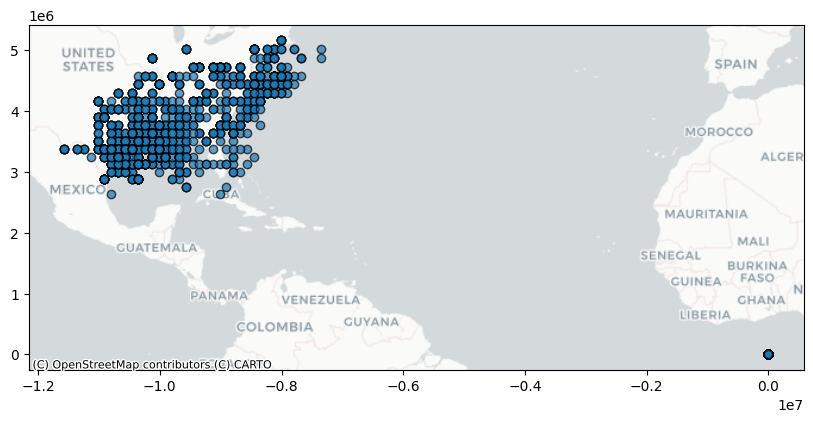

In [122]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt


# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    a,
    geometry=gpd.points_from_xy(a['long'], a['lat']),
    crs="EPSG:4326"  # WGS84
)

# Reproject to Web Mercator for contextily basemap
gdf = gdf.to_crs(epsg=3857)

# Plot
ax = gdf.plot(figsize=(10, 10), alpha=0.7, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.show()


<Axes: xlabel='Unnamed: 0.1', ylabel='Unnamed: 0'>

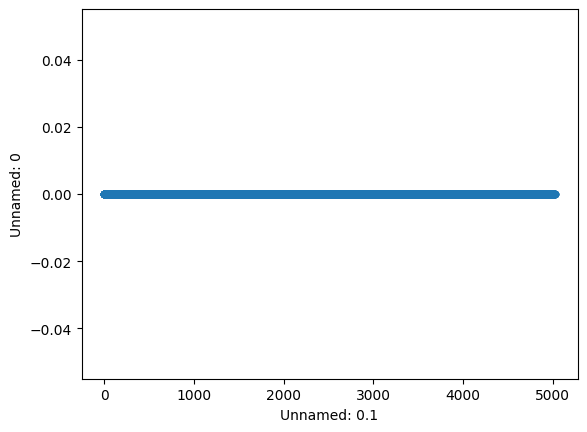

In [142]:
a.plot(x="Unnamed: 0.1", y="Unnamed: 0", kind="scatter")

In [137]:
(a['lat'] != 0).sum()

np.int64(1633)

In [134]:
(a['HurIdx'] != 0).sum()

np.int64(9742)

<Axes: xlabel='lat', ylabel='LATITUDE'>

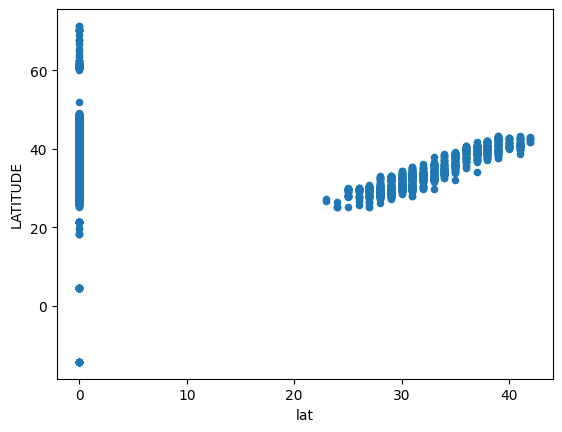

In [130]:
a.plot(x="lat", y="LATITUDE", kind="scatter")

In [57]:
a['yr'] = a['DATE'].dt.year

The column 'diftime' will have an nan (not a number) value anytime no hurricanes have come within 300 miles of the fail point.

In [62]:
b = a.dropna(subset=['diftime'])
b.shape

(9742, 45)

In [59]:
a = None

In [60]:
#NOAHURDAT Data
# Can we pull this directly from an internet url?

hur  = pd.read_csv("../raw_data/NOAAHURDAT.csv")
hur = hur.sort_values(['date'])
hur = hur.sort_values(['start_date'])
hur = hur.sort_values(['end_date'])
hur['dateTime'] = hur['start_date'].astype(str).str.cat(hur['time'].astype(str),sep=" ")
hur['dateTime'] = pd.to_datetime(hur['dateTime'], format="%Y-%m-%d %H:%M:%S")

In [63]:
hur.name = hur.name.astype('category')

In [70]:
hur['Unnamed: 0']

0            0
1            1
2            2
3            3
4            4
         ...  
12225    12224
12226    12225
12227    12227
12228    12228
12229    12229
Name: Unnamed: 0, Length: 12230, dtype: int64

# Create merged PHMSA + HURDAT 2 dataset




Use the "HurIDX" column to idenfy hurdat points already affiliated with failures


In [64]:
len(hur.name.str.cat(hur.year.astype(str)).unique())

531

In [75]:
len(b.HurIdx.unique())

949

In [80]:
len(b.HurIdx[b.diftime<60].unique())

804

In [81]:
hur = hur[~hur['Unnamed: 0'].isin(b.HurIdx[b.diftime<60].unique())]
hur.shape

(11555, 21)

In [82]:
b.category = np.nan

In [83]:
test = pd.concat([b, hur], ignore_index=False)


In [84]:
b = None

Use the pipeline failure latitude column to identify wherther or not storm is associated with failure

In [85]:
test.category.unique()

array([nan, -1.,  0.,  1.,  3.,  2.,  4.,  5.])

In [86]:
test['failTF'] = np.nan

In [87]:
test.columns

Index(['Unnamed: 0.1', 'PipeIDX', 'Unnamed: 0', 'CAUSE', 'DATE',
       'INCIDENT_CITY', 'INCIDENT_COUNTY', 'INCIDENT_STATE', 'ZIP_CODE',
       'INSTALLATION_YEAR', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'MANYR',
       'TYPE', 'ITMYR', 'year', 'Point', 'PipeIdx', 'name', 'month', 'day',
       'hour', 'lat', 'long', 'status', 'category', 'wind', 'pressure',
       'tropicalstorm_force_diameter', 'hurricane_force_diameter', 'DATETIME1',
       'date', 'start_date', 'time', 'pointh', 'end_date', 'dateTime',
       'HurIdx', 'diftime', 'distance', 'frequency', 'max_int', 'fourplus',
       'yr', 'failTF'],
      dtype='object')

In [88]:
test['failTF'].iloc[np.isnan(test.LATITUDE)] = 0
test['failTF'].iloc[~np.isnan(test.LATITUDE)] = 1

C:\Users\janet\AppData\Local\Temp\ipykernel_30468\3700608382.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test['failTF'].iloc[np.isnan(test.LATITUDE)] = 0
C:\Users\janet\AppData\Local\Temp\ipykernel_30468\3700608382.py:1: SettingWithC

Assign the hurricane failure year to entries with no failure (and therefore no failure year)

In [89]:
test.yr.iloc[np.isnan(test.yr)] = test['year'][np.isnan(test.yr)]

C:\Users\janet\AppData\Local\Temp\ipykernel_30468\2328410309.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test.yr.iloc[np.isnan(test.yr)] = test['year'][np.isnan(test.yr)]
C:\Users\janet\AppData\Local\Temp\ipykernel_30468\2328410309.p

In [90]:
test['DATE'] = pd.to_datetime(test['DATE'])#, errors='coerce')
test.month = test['DATE'].dt.month
test.name.loc[(test.name=="0") & (test.month.isin([1,2,3,4,5,6]))]="NoStorm"

C:\Users\janet\AppData\Local\Temp\ipykernel_30468\3703648613.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  test.name.loc[(test.name=="0") & (test.month.isin([1,2,3,4,5,6]))]="NoStorm"
C:\Users\janet\AppData\Local\Temp\ipykernel_30468\3

In [91]:
test.size

979662

In [92]:
#remove all rows with "0" values in the "name" column
test = test[test.name != "0"]

In [93]:
test.size

828736

In [94]:
test['yr'] = test['yr'].astype('str')
test['name'] = test['name'].astype('str')
test['name'] = test['name'] + test['yr']
test['name'] = test.name.str.split('.').str[0]

In [95]:
test['yr'] = test['yr'].astype('category')
test['name'] = test['name'].astype('category')

In [97]:
len(np.unique(test.name))

579

In [102]:
len(np.unique(test.name[test.diftime<60]))

157

In [103]:
len(test.diftime<60)

18016

In [50]:
test['ptlat']=np.nan
test['ptlong']=np.nan

In [51]:
hurf = hur
hurf['year'] = hurf['year'].astype('str')
hurf['name'] = hurf['name'].astype('str')

hurf['name'] = hurf['name'] + hurf['year']

In [52]:
minlat = hurf[['lat','name']].groupby(by = "name").min()
minlat = minlat.rename(columns={"lat": "minlat"})

minlon = hurf[['long','name']].groupby(by = "name").min()
minlon = minlon.rename(columns={"long": "minlong"})

In [53]:
hurf = None
hur = None

In [54]:
test = pd.merge(test, minlon, left_on='name', right_on = "name", how="left" )
test = pd.merge(test, minlat, left_on='name', right_on = "name", how="left" )

In [55]:
test.columns

Index(['Unnamed: 0', 'PipeIDX', 'Unnamed: 0.1', 'CAUSE', 'DATE',
       'INCIDENT_CITY', 'INCIDENT_COUNTY', 'INCIDENT_STATE', 'ZIP_CODE',
       'INSTALLATION_YEAR', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'MANYR',
       'TYPE', 'ITMYR', 'year', 'Point', 'PipeIdx', 'name', 'month', 'day',
       'hour', 'lat', 'long', 'status', 'category', 'wind', 'pressure',
       'tropicalstorm_force_diameter', 'hurricane_force_diameter', 'DATETIME1',
       'date', 'start_date', 'time', 'pointh', 'end_date', 'dateTime',
       'HurIdx', 'diftime', 'distance', 'frequency', 'max_int', 'fourplus',
       'yr', 'failTF', 'ptlat', 'ptlong', 'minlong', 'minlat'],
      dtype='object')

In [66]:
test.wind.iloc[test.wind==0]=12
test.pressure.iloc[test.pressure==0]=1050
test.minlat.iloc[test.minlat.isnull()]=float(minlat.max())
test.minlong.iloc[test.minlong.isnull()]=float(minlon.min())

In [61]:
test.minlong.isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
18099    False
18100    False
18101    False
18102    False
18103    False
Name: minlong, Length: 18104, dtype: bool

In [71]:
test.CAUSE = test.CAUSE.astype(str)
test.CAUSE.iloc[test.CAUSE == 'DAMAGE BY OUTSIDE FORCES']='outside'
test.CAUSE.iloc[test.CAUSE == 'CONSTRUCTION DEFECT/MATERIAL FAILURE']='outside'
test.CAUSE.iloc[test.CAUSE == 'CORROSION']='outside'
test.CAUSE.iloc[test.CAUSE == 'OTHER']='outside'
test.CAUSE.iloc[test.CAUSE == 'CONSTRUCTION/OPERATING ERROR']='human'
test.CAUSE.iloc[test.CAUSE == 'DAMAGE BY OUTSIDE FORCE']='outside'
test.CAUSE.iloc[test.CAUSE == 'CONSTRUCTION/MATERIAL DEFECT']='outside'
test.CAUSE.iloc[test.CAUSE == 'ACCIDENTALLY CAUSED BY OPERATOR']='outside'
test.CAUSE.iloc[test.CAUSE =='OUTSIDE FORCE DAMAGE']='outside'
test.CAUSE.iloc[test.CAUSE =='FAILED PIPE']= 'outside'
test.CAUSE.iloc[test.CAUSE =='FAILED WELD']='outside',
test.CAUSE.iloc[test.CAUSE == 'MALFUNCTION OF CONTROL OR RELIEF EQUIPMENT']= 'outside'
test.CAUSE.iloc[test.CAUSE =='INCORRECT OPERATION BY OPERATOR PERSONNEL']= 'human'
test.CAUSE.iloc[test.CAUSE =='EXCAVATION DAMAGE']='human'
test.CAUSE.iloc[test.CAUSE =='OTHER OUTSIDE FORCE DAMAGE']='outside'
test.CAUSE.iloc[test.CAUSE =='INCORRECT OPERATION']= 'human'
test.CAUSE.iloc[test.CAUSE =='MATERIAL AND/OR WELD FAILURES']='outside'
test.CAUSE.iloc[test.CAUSE == 'EQUIPMENT']='outside'
test.CAUSE.iloc[test.CAUSE =='NATURAL FORCES']='natural'
test.CAUSE.iloc[test.CAUSE =='EQUIPMENT FAILURE']='outside'
test.CAUSE.iloc[test.CAUSE =='CORROSION FAILURE']='outside'
test.CAUSE.iloc[test.CAUSE =='MATERIAL FAILURE OF PIPE OR WELD']='outside'
test.CAUSE.iloc[test.CAUSE =='NATURAL FORCE DAMAGE']= 'natural'
test.CAUSE.iloc[test.CAUSE =='OTHER INCIDENT CAUSE']='outside'

In [72]:
test.CAUSE=test.CAUSE.astype('category')
test.CAUSE.unique()

['outside', 'human', 'natural', 'nan']
Categories (4, object): ['human', 'nan', 'natural', 'outside']

In [73]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [74]:
N_a= world.loc[world['name'] == 'United States of America']
N_a_p= world.loc[world['continent'] == 'North America']

In [79]:
N_a.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [75]:
world = None

In [80]:
gdf = gpd.GeoDataFrame(
    test, geometry=gpd.points_from_xy(test.ptlong, test.ptlat), crs="EPSG:4326"
)

In [82]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [81]:
#N_a = N_a.to_crs()
gdfclip = gpd.clip(gdf, N_a.buffer(0.35))
gdfclip.shape

C:\Apps-SU\Anaconda3\envs\geoplot_compatible\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
C:\Apps-SU\Anaconda3\envs\geoplot_compatible\lib\site-packages\geopandas\array.py:918: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
C:\Apps-SU\Anaconda3\envs\geoplot_compatible\lib\site-packages\geopandas\array.py:919: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
C:\Apps-SU\Anaconda3\envs\geoplot_compatible\lib\site-packages\geopandas\array.py:920: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
C:\Apps-SU\Anaconda3\envs\geoplot_compatible\lib\site-packages\geopandas\array.py:921: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


(0, 51)

In [ ]:
sum(test.failTF)

In [ ]:
gdfclip[gdfclip.failTF==1].shape

In [ ]:
gdfclip.columns

In [ ]:
f, ax1 = plt.subplots(figsize=(10, 6))
N_a_p.plot(ax=ax1,facecolor="none", edgecolor='black',)
gdfclip.plot(ax=ax1,
            column=gdfclip.failTF, cmap='Paired',
            markersize=20, legend= True
           )

#overlap.plot(ax=ax1, color='black',
#                markersize=50
#                )

ax1.set(title="Pipeline Failures by cause")
plt.show()

In [ ]:
np.random.seed(0)
kmeans = KMeans(n_clusters=6, random_state=0, n_init="auto").fit(gdfclip[['ptlat', 'ptlong']])
gdfclip['locGrp']=kmeans.predict(gdfclip[['ptlat', 'ptlong']])
gdfclip.locGrp=gdfclip.locGrp.astype('category')

In [ ]:
# Format and plot your results from task 2
# Format and plot your results from task 2
f, ax1 = plt.subplots(figsize=(10, 6))
N_a_p.plot(ax=ax1,facecolor="none", edgecolor='black',)
gdfclip.plot(ax=ax1,
            column=gdfclip.locGrp,cmap="tab10",
            markersize=10, legend= True
           )

N_a.plot(ax=ax1,facecolor="none", edgecolor='black',)

ax1.set(title="Pipeline Failures location groups")
plt.show()


## Save binomial fail Y/N merge

In [ ]:
binom = gdfclip[["PipeIDX", "CAUSE", "LATITUDE", "LONGITUDE", "yr", 'lat', 'long', 'status', 'category', 'wind', 'pressure',
       'tropicalstorm_force_diameter', 'hurricane_force_diameter','HurIdx', 'diftime', 'distance', 'frequency', 'max_int', 'fourplus',
       'yr', 'failTF', 'locGrp', 'ptlong', 'ptlat', 'minlong','minlat']]

In [ ]:
binom.to_csv("analysis_ready_binomial.csv")

In [ ]:
binom = None

In [ ]:
test = None

##Part 2: Frequency data

Frequency counts for mixed effects model:


In [ ]:
#Collapse dataframe
ard = gdfclip[['INSTALLATION_YEAR','name','lat', 'long', 'status', 'category', 'wind', 'pressure', 'tropicalstorm_force_diameter', 'hurricane_force_diameter','date', 'yr', 'failTF','locGrp', 'ptlong', 'ptlat', 'minlong','minlat']]

In [ ]:
gdfclip = None

In [ ]:
ard.locGrp = ard.locGrp.astype('category')
ard.name = ard.name.astype('category')
ard.yr = ard.yr.astype('category')

In [ ]:
ard1 =ard[['name','locGrp', 'yr','category','wind','pressure',  "minlong",'ptlat','failTF', 'minlat', 'ptlong']].groupby(by=['name', 'locGrp','yr']).agg(
    {'ptlat': ['mean'], 'ptlong': ['mean'], 'wind':['max'], 'pressure':['min'], 'minlong':['min'], 'minlat':['min'], 'failTF':['sum']}).reset_index()
ard1 = ard1.dropna()
ard1.columns = ['name','locGrp', 'yr','ptlat_mean', 'ptlong_mean', 'wind_max', 'pressure_min', 'minlong_min', 'minlat_min','failTF_sum']
ard1.head()

In [ ]:
ard1.shape

In [ ]:
ard1.to_csv("analysis_ready.csv")